In [12]:
import boto3
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.circuits import Circuit

# Installation

In [2]:
!pip install amazon-braket-ocean-plugin

In [3]:
!pip install dwave-ocean-sdk

# Defining the QUBO

In [13]:
import qubovert
import numpy as np
import networkx as nx

In [48]:
class VRPstate:
    def __init__(self, G, num_vehicles):
        self.num_nodes = len(G.nodes)
        self.num_vehicles = num_vehicles
        self.G = G # depot is always node 0
        self.vehicle_locations = [0 for _ in range(self.num_vehicles)]
        self.vehicle_routes = [[] for _ in range(self.num_vehicles)]
        self.visited_nodes = [0 for _ in range(self.num_nodes)]
        
        self.qubo = None
        self.C = None

    def get_cost_matrix(self):
        C = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            for j in range(i+1, self.num_nodes):
                if self.G.has_edge(i,j): # edge exists
                    C[i,j] = self.G[i][j]['weight']
                    C[j,i] = C[i,j]
                else: # edge doesnt exist
                    path = nx.shortest_path(self.G, source=i, target=j, weight='weight')
                    C[i,j] = sum([self.G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1)]) * 10 * 3**len(path)
                    C[j,i] = C[i,j]
        self.C = C
    
    def A_func(self, A_2, binary_vars):
        for i in range(len(binary_vars)):
            for j in range(i+1, len(binary_vars)):
                self.qubo[(binary_vars[i], binary_vars[j])] += A_2 * 2
        
        for var in binary_vars:
            self.qubo[(var,)] -= A_2 * 1
    
    def add_constraints(self, A_2):
        # Ensure each node is visited by a single vehicle
        for k in range(self.num_nodes):
            binary_vars = []
            for vehicle in range(self.num_vehicles):
                for timestep in range(self.num_nodes):
                    binary_vars.append((vehicle, k, timestep))
            self.A_func(A_2, binary_vars)
            
        # Each vehicle is in one location at one time
        for vehicle in range(self.num_vehicles):
            for timestep in range(self.num_nodes):
                binary_vars = [(vehicle, n, timestep) for n in range(self.num_nodes)]
                self.A_func(A_2, binary_vars)
        
        # Each vehicle is in its current location at time t=0
        for m in range(self.num_vehicles):
            for n in range(self.num_nodes):
                if self.vehicle_locations[m] == n:
                    self.qubo[((m, n, 0),)] -= A_2
                else:
                    self.qubo[((m, n, 0),)] += A_2
    
    def get_qubo(self, A_1=1, A_2=1000):
        self.get_cost_matrix()
        self.qubo = qubovert.QUBO()

        # first order terms
        for i in range(self.num_vehicles):
            for j in range(1, self.num_nodes):
                # returning to depot cost
                self.qubo[((i, j, self.num_nodes),)] += A_1 * self.C[j, 0]
                
        for m in range(self.num_vehicles):
            for n in range(self.num_nodes):
                # travelling from current position cost
                self.qubo[((m, n, 1),)] += A_1 * self.C[n, self.vehicle_locations[m]]
                
        # second order terms
        for m in range(self.num_vehicles):
            for n in range(1, self.num_nodes):
                for i in range(self.num_nodes):
                    for j in range(self.num_nodes):
                        # Add second order term to qubo
                        self.qubo[((m, i, n), (m, j, n+1))] += A_1 * self.C[i, j]
                            
        # Add constraint term Q
        self.add_constraints(A_2)
     
        return self.qubo
    
    def print_routes(self, best_state):
        for vehicle in range(self.num_vehicles):
            total_cost = 0    
            print(f'Vehicle {vehicle}:')
            cur_path = sorted([key for key, val in best_state.items() if val == 1 and key[0] == vehicle], key=lambda v: v[2])
            print(f'\t{self.vehicle_locations[vehicle]} --> ', end='')
            prev_stop = self.vehicle_locations[vehicle]
            for stop in cur_path:
                total_cost += state.C[prev_stop, stop[1]]
                prev_stop = stop[1]
                print(f'{stop[1]} --> ', end='')
            print('END')

            # total cost
            print('\t Total Cost =', total_cost)
            
    def parse_results(self, result, dwave=False):
        """
        NOTE: this function assumes num_vehicles = 1
        
        Walk through the paths returned by the QUBO solver,
        remove duplicates, and compute the cost of the pruned path.
        """
        all_paths = []
        for res in result:
            pruned_path = []
            for vehicle in range(self.num_vehicles):
                total_cost = 0    
                if dwave:
                    solution = res['solution']
                else:
                    solution = res.state
                cur_path = sorted([key for key, val in solution.items() if val == 1 and key[0] == vehicle], key=lambda v: v[2])
                prev_stop = self.vehicle_locations[vehicle]
                for stop in cur_path:
                    if not stop[1] in pruned_path:
                        pruned_path.append(stop[1])
                        total_cost += state.C[prev_stop, stop[1]]
                        prev_stop = stop[1]
                        
            for node in G.nodes:
                if not node in pruned_path:
                    pruned_path.append(node)
                    
            all_paths.append((pruned_path, total_cost))
        
        return sorted(all_paths, key=lambda v: v[1])[0]

[[ 0.  1. 10.  7.  4.  3.  9.]
 [ 1.  0.  1.  9.  5.  1.  1.]
 [10.  1.  0.  3.  9.  5.  3.]
 [ 7.  9.  3.  0.  3.  3. 10.]
 [ 4.  5.  9.  3.  0.  9.  2.]
 [ 3.  1.  5.  3.  9.  0.  1.]
 [ 9.  1.  3. 10.  2.  1.  0.]]
Create QUBO with 56 variables and 601 terms


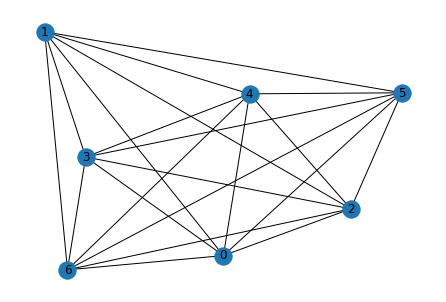

In [49]:
G = nx.Graph()
N = 7
#G.add_edges_from([(0,4,{'weight':1}), (4,3,{'weight':1}), (1,3,{'weight':1}),
#                  (1,7,{'weight':1}),(7,8,{'weight':1}), (8,6,{'weight':1}), (6,2,{'weight':1}),
#                  (5,4,{'weight':1}),(5,7,{'weight':1}), (5,9,{'weight':1}), (9,11,{'weight':1}),
#                  (11,10,{'weight':1}),(9,12,{'weight':1}), (12,11,{'weight':1}),])
#G.add_edges_from([(0,1,{'weight':1}), (1,2,{'weight':1}), (0,3,{'weight':1}),
#                  (3,4,{'weight':1}),])
edge_list = []
for i in range(N):
    for j in range(i+1, N):
        edge_list.append((i,j,{'weight':np.random.choice(list(range(1,11)))}))
G.add_edges_from(edge_list)


nx.draw_spring(G, with_labels=True)
state = VRPstate(G, 1)
state.get_cost_matrix()
print(state.C)

qubo = state.get_qubo()
print(f'Create QUBO with {qubo.num_binary_variables} variables and {qubo.num_terms} terms')

In [50]:
result = qubovert.sim.anneal_qubo(qubo.Q, num_anneals=4, anneal_duration=int(1e6))
for i, res in enumerate(result):
    print('Anneal', i+1)
    state.print_routes(res.state)
    print()

Anneal 1
Vehicle 0:
	0 --> 0 --> 6 --> 3 --> 1 --> 4 --> 2 --> 5 --> END
	 Total Cost = 47.0

Anneal 2
Vehicle 0:
	0 --> 0 --> 3 --> 5 --> 6 --> 1 --> 4 --> 2 --> END
	 Total Cost = 26.0

Anneal 3
Vehicle 0:
	0 --> 0 --> 1 --> 6 --> 3 --> 2 --> 4 --> 5 --> END
	 Total Cost = 33.0

Anneal 4
Vehicle 0:
	0 --> 0 --> 3 --> 4 --> 5 --> 6 --> 2 --> 1 --> END
	 Total Cost = 24.0



In [51]:
state.parse_results(result)

([0, 3, 4, 5, 6, 2, 1], 24.0)

In [23]:
result.best.value

-280.0

In [8]:
qubo

{((0, 1, 5),): 1.0,
 ((0, 2, 5),): 16.0,
 ((0, 3, 5),): 1.0,
 ((0, 4, 5),): 16.0,
 ((0, 1, 1),): -199.0,
 ((0, 2, 1),): -184.0,
 ((0, 3, 1),): -199.0,
 ((0, 4, 1),): -184.0,
 ((0, 0, 1), (0, 1, 2)): 1.0,
 ((0, 0, 1), (0, 2, 2)): 16.0,
 ((0, 0, 1), (0, 3, 2)): 1.0,
 ((0, 0, 1), (0, 4, 2)): 16.0,
 ((0, 0, 2), (0, 1, 1)): 1.0,
 ((0, 1, 1), (0, 2, 2)): 1.0,
 ((0, 1, 1), (0, 3, 2)): 16.0,
 ((0, 1, 1), (0, 4, 2)): 48.0,
 ((0, 0, 2), (0, 2, 1)): 16.0,
 ((0, 1, 2), (0, 2, 1)): 1.0,
 ((0, 2, 1), (0, 3, 2)): 48.0,
 ((0, 2, 1), (0, 4, 2)): 128.0,
 ((0, 0, 2), (0, 3, 1)): 1.0,
 ((0, 1, 2), (0, 3, 1)): 16.0,
 ((0, 2, 2), (0, 3, 1)): 48.0,
 ((0, 3, 1), (0, 4, 2)): 1.0,
 ((0, 0, 2), (0, 4, 1)): 16.0,
 ((0, 1, 2), (0, 4, 1)): 48.0,
 ((0, 2, 2), (0, 4, 1)): 128.0,
 ((0, 3, 2), (0, 4, 1)): 1.0,
 ((0, 0, 2), (0, 1, 3)): 1.0,
 ((0, 0, 2), (0, 2, 3)): 16.0,
 ((0, 0, 2), (0, 3, 3)): 1.0,
 ((0, 0, 2), (0, 4, 3)): 16.0,
 ((0, 0, 3), (0, 1, 2)): 1.0,
 ((0, 1, 2), (0, 2, 3)): 1.0,
 ((0, 1, 2), (0, 3, 3)): 16.0,

# Submitting to DWave

In [44]:
# pip install dwave-ocean-sdk
# pip install amazon-braket-ocean-plugin
import dwave.system
import braket.ocean_plugin

In [52]:
arn = "arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6"
#arn = "arn:aws:braket:::device/qpu/d-wave/Advantage_system1"
my_bucket = f"amazon-braket-qbraid-jobs" # the name of the bucket
my_prefix = "tomeshteague-40gmail-2ecom" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

shots = 10

sampler = dwave.system.EmbeddingComposite(
            braket.ocean_plugin.BraketDWaveSampler(s3_folder, arn)
        )

response = sampler.sample_qubo(qubo.Q, num_reads=shots)
record = response.record

solution = []
for row in record.sample:
    soln_dict = {}
    for var, assignment in zip(response.variables, row):
        soln_dict[var] = assignment
    solution.append(soln_dict)

return_data = [
    (s, e, n) for s, e, n in zip(solution, record.energy, record.num_occurrences)
]

return_recarray = np.rec.array(
    return_data, dtype=[("solution", "O"), ("energy", "<f8"), ("num_occurrences", "<i8")]
)

#print(return_recarray)

In [53]:
for i, res in enumerate(return_recarray):
    print('Anneal', i+1)
    state.print_routes(res['solution'])
    print('\tQUBO cost:', res['energy'])
    print()

Anneal 1
Vehicle 0:
	0 --> 0 --> 0 --> 1 --> 2 --> 3 --> 4 --> 5 --> 6 --> 3 --> 4 --> 6 --> END
	 Total Cost = 33.0
	QUBO cost: -12936.0

Anneal 2
Vehicle 0:
	0 --> 0 --> 2 --> 3 --> 6 --> 4 --> 1 --> 5 --> 1 --> 2 --> 3 --> 6 --> END
	 Total Cost = 46.0
	QUBO cost: -14932.0

Anneal 3
Vehicle 0:
	0 --> 0 --> 3 --> 1 --> 4 --> 5 --> 5 --> 1 --> 2 --> 4 --> END
	 Total Cost = 41.0
	QUBO cost: -10947.0

Anneal 4
Vehicle 0:
	0 --> 0 --> 1 --> 6 --> 2 --> 4 --> 5 --> 3 --> 4 --> 6 --> END
	 Total Cost = 31.0
	QUBO cost: -12951.0

Anneal 5
Vehicle 0:
	0 --> 0 --> 2 --> 3 --> 4 --> 1 --> 6 --> 1 --> 2 --> 4 --> 6 --> END
	 Total Cost = 35.0
	QUBO cost: -10943.0

Anneal 6
Vehicle 0:
	0 --> 0 --> 3 --> 1 --> 2 --> 4 --> 6 --> 5 --> 1 --> 3 --> 6 --> END
	 Total Cost = 49.0
	QUBO cost: -12949.0

Anneal 7
Vehicle 0:
	0 --> 0 --> 4 --> 3 --> 1 --> 5 --> 6 --> 2 --> 3 --> 5 --> 6 --> END
	 Total Cost = 28.0
	QUBO cost: -10937.0

Anneal 8
Vehicle 0:
	0 --> 0 --> 3 --> 1 --> 2 --> 6 --> 4 --> 6 --> 

In [54]:
state.parse_results(return_recarray, dwave=True)

([0, 1, 2, 3, 4, 5, 6], 18.0)

In [5]:
def get_cost(temporary_route, current_position, cost):
    #Input:
        #a temporary_route list, current_positions list of vehicles, cost matrix
    #output 
        #the cost (int)
    if(len(temporary_route) == 1):
        return 0
    k = current_position 
    path_cost = 0
    
    for i in temporary_route:
        path_cost += cost[k][i]
        k = i
    
    return path_cost

In [4]:
#assign the cars based on their current position

def get_the_partitioned_path(solution, cost, current_position_list, num_vehicle = 2):
    #Input:
        #a solution path list, current_positions list of vehicles, num_vehicles
    #output 
        #the path each vehicle should take [[vehicle 0 path],[vehicle 1 path]...[vehicle (num_vehicles-1) path]] 
    final_route = [[current_position_list[i]] for i in range(num_vehicle)]#starting with the current position

    for i in solution[0][1:]:#adding the last index to use the vehicle_locations list
        candidate = -1
        the_cost = 1e5 #not efficient but it works
        
        for k in range(num_vehicle):
            print(f'Path {final_route[k][-1]} to {i} cost is: {get_cost(final_route[k],current_position_list[k], cost)}')
            if(the_cost>get_cost(final_route[k]+[i], current_position_list[k], cost)):
                candidate = k
                the_cost = get_cost(final_route[k]+[i],current_position_list[k], cost)
            #update the candidate's route
        print(f'chosen vehicle {candidate}')
        final_route[candidate].append(i)  
        
    return final_route

In [ ]:
get_the_partitioned_path(state.parse_results(result),state.C,vehicle_locations,num_vehicles)